<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 구글드라이브와 Colab 연동

In [1]:
#HuggingFace는 자연어 처리 인공지능 모델에서, BERT 모델 같은 트랜스포머 모델들을 쉽게 다룰 수 있게 해주는 패키지임
#!pip install transformers //2022.05.18 수정(에러 정정)
!pip install transformers==3.1.0

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/My\ Drive/AISecurity

/content/drive/My Drive/AISecurity


In [4]:
print(os.getcwd())
!ls

/content/drive/My Drive/AISecurity
 11_Attention.ipynb
 11_nmt_with_attention_사본.ipynb
 11_nmt_with_attention.ipynb
 12_transformer.ipynb
'13_BERT Classification.ipynb'
 2_TFIDF.ipynb
 3_SimpleCrawling.ipynb
 4_MeCab.ipynb
 4_Pre_Processing.ipynb
 5_OneHotEncode.ipynb
 5_Word2Vec-FastText.ipynb
 6_Similarity.ipynb
 6_TopicModeling_bak.ipynb
 6_TopicModeling.ipynb
 7_ngram.ipynb
 9-1_RNN.ipynb
 9-1_rnn.py
 9-2_LSTM.ipynb
 9-3_GRU.ipynb
 9-4_BLSTM.ipynb
'(bak)(11_attention.ipynb'
'(Bak)12_Transformer.ipynb'
'(bak)13_BERT Classification.ipynb'
 convert_tensorflow_1_to_tensorflow_2_on_google_colab.ipynb
 deu.txt
 eng-fra.txt
 kor.txt
 model.pt
 multi_cased_L-12_H-768_A-12
 ratings.txt
 report.txt
 Sample.ipynb
 spam.csv
 spam_test.csv
 spam_train.csv
 spa.txt
 temp2.ipynb
 temp.py
 training_checkpoints


## 2. 관련 패키지 선언


In [5]:
import tensorflow as tf

#import tensorflow.compat.v1 as tf
tf.config.experimental_run_functions_eagerly(True)

import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os

## 3. 스팸데이터셋 준비

In [6]:
# 제공된 Spam data 읽기
train = pd.read_csv("spam_train.csv")
test = pd.read_csv("spam_test.csv")

In [7]:
train.head(100)


,label,document,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,�� dun need to pick ur gf?,NaN,NaN,NaN
1,0,Yay! You better not have told that to 5 other ...,NaN,NaN,NaN
2,0,Horrible u eat macs eat until u forgot abt me ...,NaN,NaN,NaN
3,0,"Did he say how fantastic I am by any chance, o...",NaN,NaN,NaN
4,0,Just nw i came to hme da..,NaN,NaN,NaN
...,...,...,...,...,...
95,1,Can U get 2 phone NOW? I wanna chat 2 set up m...,NaN,NaN,NaN
96,0,"Tee hee. Off to lecture, cheery bye bye.",NaN,NaN,NaN
97,0,"Sorry chikku, my cell got some problem thts y ...",NaN,NaN,NaN
98,0,If you still havent collected the dough pls le...,NaN,NaN,NaN


In [8]:
# Label의 1은 spam document에 해당함, 0은 정상 
train[50:70]

,label,document,Unnamed: 2,Unnamed: 3,Unnamed: 4
50,0,Rofl betta invest in some anti aging products,NaN,NaN,NaN
51,1,You are a winner U have been specially selecte...,NaN,NaN,NaN
52,0,"sir, you will receive the account no another 1...",NaN,NaN,NaN
53,1,Reply with your name and address and YOU WILL ...,NaN,NaN,NaN
54,0,So �_'ll be submitting da project tmr rite?,NaN,NaN,NaN
55,1,FREE entry into our �250 weekly comp just send...,NaN,NaN,NaN
56,0,Jus ans me lar. U'll noe later.,NaN,NaN,NaN
57,0,I want to send something that can sell fast. ...,NaN,NaN,NaN
58,0,have got * few things to do. may be in * pub l...,NaN,NaN,NaN
59,0,1's finish meeting call me.,NaN,NaN,NaN


In [9]:
# 불필요한 컬럼 삭제
del train['Unnamed: 2']
del train['Unnamed: 3']
del train['Unnamed: 4']

del test['Unnamed: 2']
del test['Unnamed: 3']
del test['Unnamed: 4']

## 4. 버트 인풋 만들기


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

토큰화 확인

In [11]:
tokenizer.tokenize("Even my brother is not like to speak with me. They treat me like aids patent.")

['Even',
 'my',
 'brother',
 'is',
 'not',
 'like',
 'to',
 'speak',
 'with',
 'me',
 '.',
 'They',
 'treat',
 'me',
 'like',
 'aid',
 '##s',
 'patent',
 '.']

In [12]:
tokenizer.tokenize("내일까지는 10만원 입금이 필요합니다")

['내',
 '##일',
 '##까지',
 '##는',
 '10',
 '##만',
 '##원',
 '입',
 '##금',
 '##이',
 '필',
 '##요',
 '##합',
 '##니다']

In [13]:

def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(스팸 : 1 정상 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 20
# 스팸 문장을 포함하고 있는 칼럼
DATA_COLUMN = "document"
# 스팸인지를 (1=스팸,0=정상) 포함하고 있는 칼럼
LABEL_COLUMN = "label"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 4399/4399 [00:04<00:00, 896.96it/s]


In [14]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 1173/1173 [00:01<00:00, 1002.73it/s]


사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [15]:
train_x

[array([[  101,   100, 23145, ...,     0,     0,     0],
        [  101, 25148, 10157, ...,     0,     0,     0],
        [  101, 20220, 24874, ...,     0,     0,     0],
        ...,
        [  101, 79321, 10157, ...,     0,     0,     0],
        [  101, 10117, 75980, ...,     0,     0,     0],
        [  101,   155, 20324, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

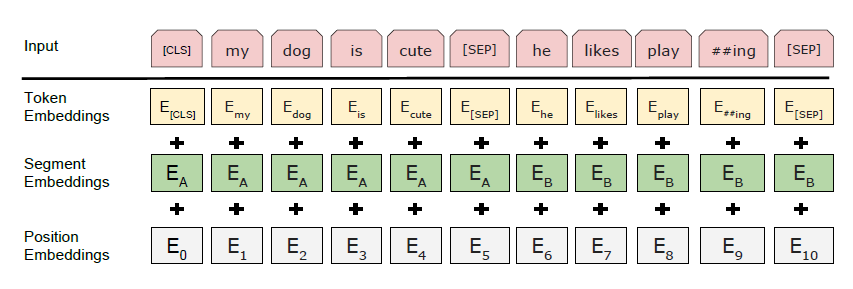

이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
인풋은 총 2개가 들어갑니다

* (토큰) 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것

* (세그멘트) 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.

* (포지션) 단어 순서에 따라서 자동으로 부여됩니다.

# 버트를 활용한 스팸분석 모델 만들기
버트 훈련을 빠르게 하기 위해, TPU를 사용하도록 하겠습니다

In [16]:
# TPU 객체 지정
TPU = False
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass

In [17]:
!pip install tensorflow-addons==0.6.0

In [18]:
# Rectified Adam 옵티마이저 사용
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)

In [19]:
def create_spam_bert():
  # 버트 pretrained 모델 로드
  model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
  # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
  # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  spam_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
  spam_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], spam_first)

  spam_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
  return spam_model

In [20]:
!pip install h5py==2.10.0 --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.14.0 requires tensorboard<1.15.0,>=1.14.0, but you have tensorboard 2.0.2 which is incompatible.
tensorflow 1.14.0 requires tensorflow-estimator<1.15.0

In [ ]:
# TPU 실행 시
if TPU:
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
# 함수를 strategy.scope로 묶어 줌
  with strategy.scope():
    spam_model = create_spam_bert()
  
  spam_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=100, validation_data=(test_x, test_y))
else:
  # GPU 모드로 훈련시킬 때
  spam_model = create_spam_bert()
  
  spam_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=100, validation_data=(test_x, test_y))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Train on 4399 samples, validate on 1173 samples
Epoch 1/4


훈련 및 성능 검증

In [ ]:
# 모델 저장
spam_model.save_weights("/huggingface_bert.h5")

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [ ]:
test_set = predict_load_data(test)

In [ ]:
test_set

In [ ]:
with strategy.scope():
  preds = spam_model.predict(test_set)

In [ ]:
# 스팸이면 1, 정상이면 0 출력
preds

우리가 훈련한 모델을 F1 SCORE를 바탕으로 성능 측정
F1 SCORE는 precision과 recall을 가중평균하여 계산합니다
recall은 (모델이 TRUE라고 판정한 것의 숫자)/(전체 TRUE의 숫자)
precision은 (진짜 TRUE) / (모델이 TRUE라고 판정한 것의 숫자)

In [ ]:
from sklearn.metrics import classification_report
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

실제 데이터로 실습하기

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def spam_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = spam_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
      print("(정상 확률 : %.2f) 정상입니다." % (1-predict_value))
    elif predict_answer == 1:
      print("(스팸 확률 : %.2f) 스팸입니다." % predict_value)

In [ ]:
spam_evaluation_predict("FREE entry into our �250 weekly comp just send")

In [ ]:
spam_evaluation_predict("How are you?")